In [1]:
import pandas as pd
import numpy as np
import gc
import os
import sys
import glob
import argparse

import torch
from fastai.vision.all import DataLoader
from datasets.dataset import RNADataset, collate_fn
from models.model import RNARegModel
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/tmp/ipykernel_100893/2184296566.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
class CFG:
    max_len = -1
    dynamic_len = True
    mixed_precision = True

    device = 'cuda:0'
    num_workers = 8
    batch_size = 256
    dim = 192
    num_layers = 12
    num_heads = 4

    exist_skip = True
    df_name = 'test_sequences_new.parquet'
    pq_suffix = '-sub'
    root_dir = '.'
    data_dir = '../datamount'
    output_dir = '../outputs'
    model_dir = 'model_ckpts'
    filename = 'submission.parquet'

In [3]:
def get_predictions(model, df, cfg):
    ds = RNADataset(df, mode='test', SN_filter=False, dir=cfg.data_dir)
    dl = DataLoader(ds,
                    batch_size=cfg.batch_size,
                    shuffle=False,
                    sampler=None,
                    num_workers=cfg.num_workers,
                    persistent_workers=True,
                    drop_last=False,
                    pin_memory=True,
                    prefetch_factor=2,
                    create_batch=lambda x: collate_fn(x, cfg.max_len, cfg.dynamic_len),
                   )
    device = cfg.device
    model = model.to(device)
    model.eval()
    _iterator = iter(dl)
    predictions = []
    with torch.no_grad():
        for step in tqdm(range(len(dl)), desc=f'predicting'):
            data, _ = next(_iterator)
            data = dict([(k, v.to(device)) for k, v in data.items()])
            with torch.cuda.amp.autocast(enabled=cfg.mixed_precision):
                result = model(data)
            predictions.append(result['react_pred'])
    return predictions

def predictions_to_sub(predictions, df):
    preds = [x.detach().cpu().float().numpy() for x in predictions]
    preds = [item for sublist in preds for item in sublist]
    preds = np.concatenate([x[:l] for x,l in zip(preds, df.seq_len.values)])
    # assert len(preds) == 269796671
    sub_df = pd.DataFrame({'id':np.arange(0, len(preds), 1), 
                               'reactivity_DMS_MaP':preds[:,1], 
                               'reactivity_2A3_MaP':preds[:,0]})
    return sub_df

# def predictions_to_df(predictions, df, max_len=206):
#     preds = [x.detach().cpu().float().numpy() for x in predictions]
#     preds = [item for sublist in preds for item in sublist]
#     preds = [x[:min(l,max_len)] for x,l in zip(preds, df.seq_len.values)]
#     preds = np.stack([np.pad(x, ((0,max_len-len(x)),(0,0)), mode='constant', constant_values=np.nan) for x in preds])
#     for i in range(max_len):
#         df.loc[:,[f'2A3_reactivity_{i+1:04d}']] = preds[:,i,0]
#     for i in range(max_len):
#         df.loc[:,[f'DMS_reactivity_{i+1:04d}']] = preds[:,i,1]
#     return df

def merge_submissions(sub_dfs, clip=True, weights=None, plot=True):
    if weights is None:
        N = len(sub_dfs)
        weights = [1./N for _ in sub_dfs]
    else:
        W = sum(weights)
        weights = [w/W for w in weights]
    print('weights:',weights)
    init = False
    for p, w in zip(sub_dfs, weights):
        df = pd.read_parquet(p)
        if not init:
            df_len = len(df)
            p_DMS = np.zeros((df_len,), dtype=np.float32)
            p_2A3 = np.zeros((df_len,), dtype=np.float32)
            init = True
        if plot:
            plt.plot(df.iloc[-457:-150,1:3])
            plt.show()
        
        p_DMS += df['reactivity_DMS_MaP'].values * w
        p_2A3 += df['reactivity_2A3_MaP'].values * w
        del df
    if clip:
        p_DMS = np.clip(p_DMS, 0, 1)
        p_2A3 = np.clip(p_2A3, 0, 1)
    sub_df = pd.DataFrame({'id':np.arange(0, df_len, 1), 
                               'reactivity_DMS_MaP':p_DMS, 
                               'reactivity_2A3_MaP':p_2A3})
    if plot:
        plt.plot(sub_df.iloc[-457:-150,1:3])
        plt.show()
    return sub_df

def make_submission(cfg, model_paths, df, filename='submission.parquet', weights=None, clip=True, exist_skip=True, output_dir='.', pq_suffix=''):
    fns = []
    for p in model_paths:
        fname = p.split('/')[-1][:-4]
        fn = f'{output_dir}/{fname}{pq_suffix}.parquet'
        if exist_skip and os.path.isfile(fn):
            print(f'file {fn} already exists, skip prediction')
            fns.append(fn)
        else:
            loaded = False
            model = RNARegModel(cfg.dim, cfg.num_layers, cfg.num_heads)
            loaded_state_dict = torch.load(f'{p}')['model']
            model.load_state_dict(loaded_state_dict, strict=True)
            model = torch.compile(model)
            print(f"loaded weights from:{p}")
                
            model.eval()
            predictions = get_predictions(model, df, cfg)
            sub = predictions_to_sub(predictions, df)
            print(f'wrote {fn}')
            sub.to_parquet(fn)
            fns.append(fn)
            del sub, predictions, model
            gc.collect()
    sub = merge_submissions(fns, clip=True, weights=weights, plot=True)
    sub.to_parquet(filename)
    print('submission file created:', filename) 
    return sub

def infer(cfg=CFG):
    os.chdir(cfg.root_dir)
    test_df = pd.read_parquet(f'{cfg.data_dir}/{cfg.df_name}')
    model_paths = glob.glob(f'{cfg.output_dir}/{cfg.model_dir}/*.pth')
    print('get predictions from:', model_paths)
    filename = f'{cfg.output_dir}/{CFG.filename}'
    make_submission(cfg, model_paths, test_df, filename, exist_skip=CFG.exist_skip, output_dir=CFG.output_dir, pq_suffix=CFG.pq_suffix)

get predictions from: ['../outputs/model_ckpts/squeeze-192-12-4-snfilter0-ep200-foldall-seed222.pth', '../outputs/model_ckpts/squeeze-192-12-4-snfilter0-ep200-foldall-seed333.pth', '../outputs/model_ckpts/squeeze-192-12-4-snfilter0-ep200-foldall-seed111.pth', '../outputs/model_ckpts/squeeze-192-12-4-snfilter1-ep60-fold2-seed2023.pth', '../outputs/model_ckpts/squeeze-192-12-4-snfilter1-ep60-fold1-seed2023.pth', '../outputs/model_ckpts/squeeze-192-12-4-snfilter1-ep60-fold4-seed2023.pth', '../outputs/model_ckpts/squeeze-192-12-4-snfilter1-ep60-fold3-seed2023.pth', '../outputs/model_ckpts/squeeze-192-12-4-snfilter1-ep60-fold0-seed2023.pth', '../outputs/model_ckpts/squeeze-192-12-4-snfilter0-ep200-foldall-seed444.pth']
loaded weights from:../outputs/model_ckpts/squeeze-192-12-4-snfilter0-ep200-foldall-seed222.pth


predicting:  25%|██████▋                    | 1310/5250 [01:51<04:43, 13.88it/s]/home/hoyso/miniconda3/envs/hoyso_ml/lib/python3.9/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/hoyso/miniconda3/envs/hoyso_ml/lib/python3.9/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/hoyso/miniconda3/envs/hoyso_ml/lib/python3.9/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/hoyso/miniconda3/envs/hoyso_ml/lib/python3.9/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
predicting: 100%|███████████████████████████| 5250/5250 [09:00<00:00,  9.71it/s]


wrote ../outputs/../outputs/model_ckpts/squeeze-192-12-4-snfilter0-ep200-foldall-seed222-sub.parquet
loaded weights from:../outputs/model_ckpts/squeeze-192-12-4-snfilter0-ep200-foldall-seed333.pth


predicting: 100%|███████████████████████████| 5250/5250 [08:32<00:00, 10.24it/s]


wrote ../outputs/../outputs/model_ckpts/squeeze-192-12-4-snfilter0-ep200-foldall-seed333-sub.parquet
loaded weights from:../outputs/model_ckpts/squeeze-192-12-4-snfilter0-ep200-foldall-seed111.pth


predicting: 100%|███████████████████████████| 5250/5250 [08:27<00:00, 10.34it/s]


wrote ../outputs/../outputs/model_ckpts/squeeze-192-12-4-snfilter0-ep200-foldall-seed111-sub.parquet
loaded weights from:../outputs/model_ckpts/squeeze-192-12-4-snfilter1-ep60-fold2-seed2023.pth


predicting: 100%|███████████████████████████| 5250/5250 [08:29<00:00, 10.30it/s]


wrote ../outputs/../outputs/model_ckpts/squeeze-192-12-4-snfilter1-ep60-fold2-seed2023-sub.parquet
loaded weights from:../outputs/model_ckpts/squeeze-192-12-4-snfilter1-ep60-fold1-seed2023.pth


predicting: 100%|███████████████████████████| 5250/5250 [08:30<00:00, 10.28it/s]


wrote ../outputs/../outputs/model_ckpts/squeeze-192-12-4-snfilter1-ep60-fold1-seed2023-sub.parquet
loaded weights from:../outputs/model_ckpts/squeeze-192-12-4-snfilter1-ep60-fold4-seed2023.pth


predicting: 100%|███████████████████████████| 5250/5250 [08:29<00:00, 10.31it/s]


wrote ../outputs/../outputs/model_ckpts/squeeze-192-12-4-snfilter1-ep60-fold4-seed2023-sub.parquet
loaded weights from:../outputs/model_ckpts/squeeze-192-12-4-snfilter1-ep60-fold3-seed2023.pth


predicting: 100%|███████████████████████████| 5250/5250 [08:28<00:00, 10.32it/s]


wrote ../outputs/../outputs/model_ckpts/squeeze-192-12-4-snfilter1-ep60-fold3-seed2023-sub.parquet
loaded weights from:../outputs/model_ckpts/squeeze-192-12-4-snfilter1-ep60-fold0-seed2023.pth


predicting: 100%|███████████████████████████| 5250/5250 [08:35<00:00, 10.19it/s]


wrote ../outputs/../outputs/model_ckpts/squeeze-192-12-4-snfilter1-ep60-fold0-seed2023-sub.parquet
loaded weights from:../outputs/model_ckpts/squeeze-192-12-4-snfilter0-ep200-foldall-seed444.pth


predicting: 100%|███████████████████████████| 5250/5250 [08:26<00:00, 10.37it/s]


wrote ../outputs/../outputs/model_ckpts/squeeze-192-12-4-snfilter0-ep200-foldall-seed444-sub.parquet
weights: [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111]


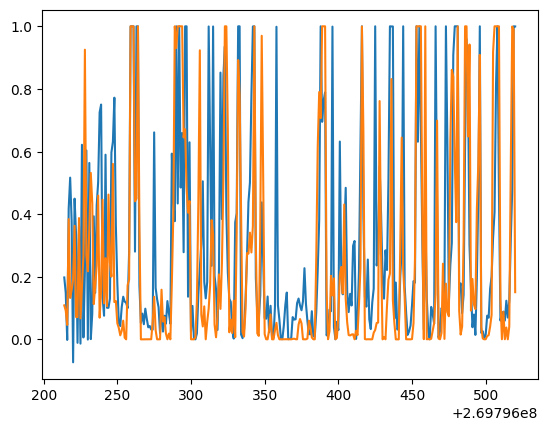

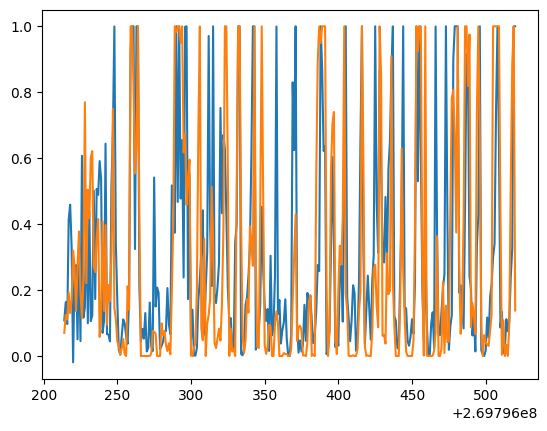

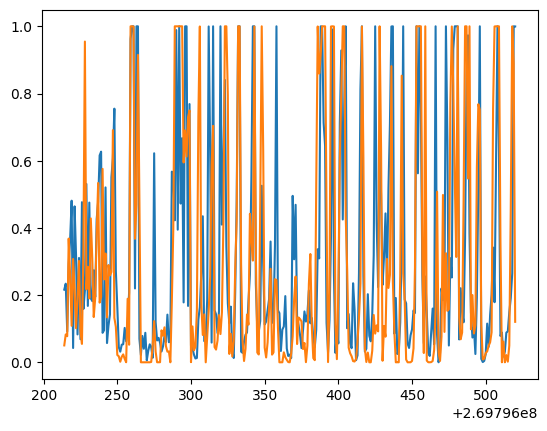

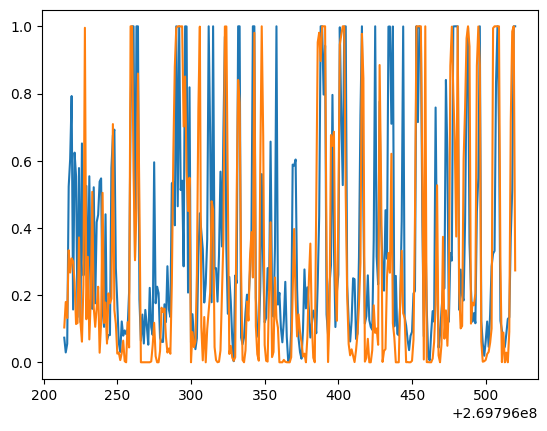

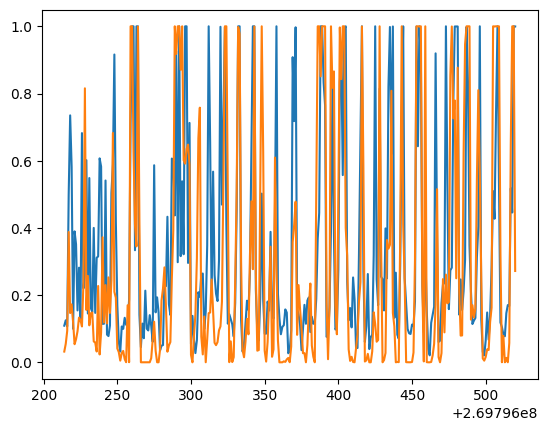

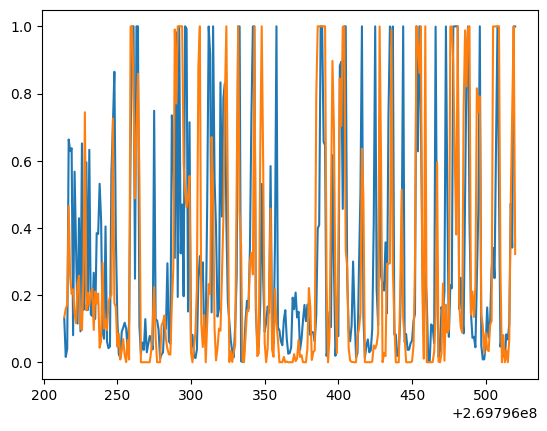

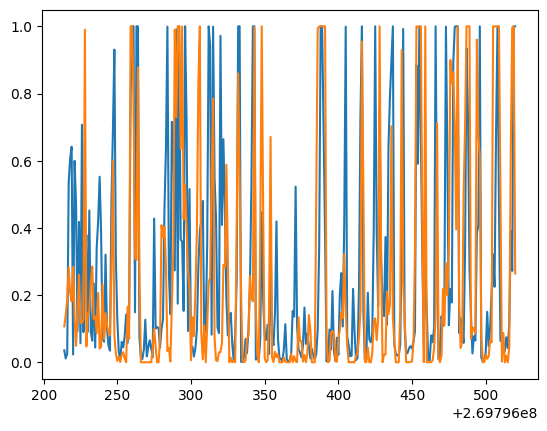

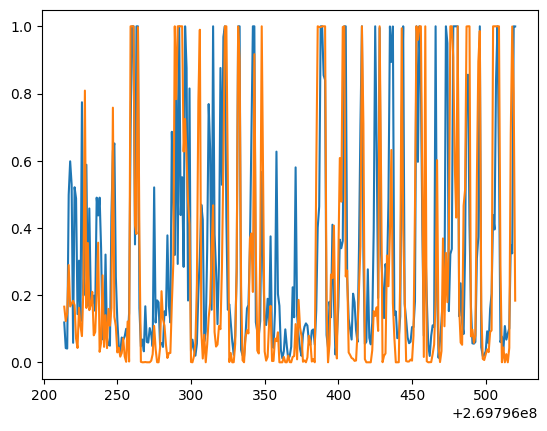

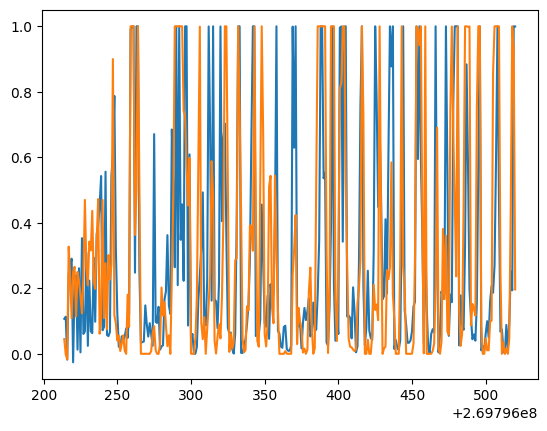

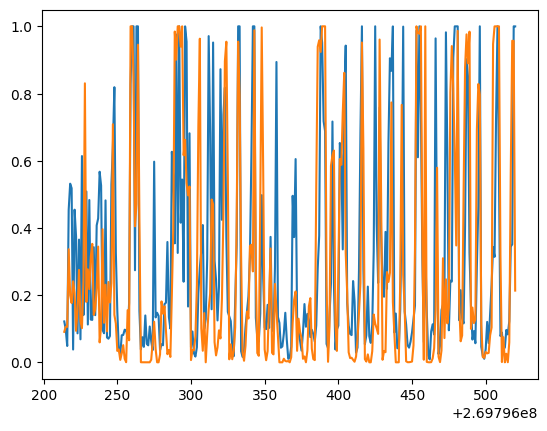

submission file created: ../outputs/submission.parquet


Process ForkProcess-28:
Process ForkProcess-12:
Process ForkProcess-16:
Process ForkProcess-14:
Process ForkProcess-27:
Process ForkProcess-11:
Process ForkProcess-13:
Process ForkProcess-9:
Process ForkProcess-32:
Process ForkProcess-31:
Process ForkProcess-22:
Process ForkProcess-20:
Process ForkProcess-26:
Process ForkProcess-30:
Process ForkProcess-15:
Process ForkProcess-1:
Process ForkProcess-19:
Process ForkProcess-7:
Process ForkProcess-17:
Process ForkProcess-18:
Process ForkProcess-3:
Process ForkProcess-21:
Process ForkProcess-25:
Process ForkProcess-2:
Process ForkProcess-24:
Process ForkProcess-23:
Process ForkProcess-29:
Process ForkProcess-8:
Process ForkProcess-10:
Process ForkProcess-5:
Process ForkProcess-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most rec

In [4]:
infer()